In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from tqdm.auto import tqdm
from rl_analysis.plotting import setup_plotting_env, savefig, clean_ticks, plot_pval

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

In [3]:
import toml

with open("../analysis_configuration.toml", "r") as f:
    analysis_config = toml.load(f)

In [4]:
data_dirs = analysis_config["data_dirs"]
proc_dirs = analysis_config["intermediate_results"]
lagged_cfg = analysis_config["dlight_lagged_correlations"]
figure_cfg = analysis_config["figures"]

In [5]:
file_suffix = "offline" if lagged_cfg["use_offline"] else "online"
load_file = os.path.join(proc_dirs["dlight"], f"dlight_snippets_{file_suffix}.parquet")

In [6]:
file, ext = os.path.splitext(load_file)
features_save_file = f"{file}_features{ext}"

if lagged_cfg["use_renormalized"]:
    file, ext = os.path.splitext(features_save_file)
    features_save_file = f"{file}_renormalize{ext}"

rle_save_file = features_save_file.replace("snippet", "usage")

dirname, filename = os.path.split(features_save_file)
file, ext = os.path.splitext(filename)
file = os.path.join(proc_dirs["dlight"], file)
if lagged_cfg["estimate_within_bin"]:
    file = f"{file}_withinbin"
results_file = f"{file}_lag_usage_and_scalars_shifted.parquet"
results_tm_file = f"{file}_lag_usage_and_scalars_shifted.npy"
corr_file = f"{file}_lag_usage_and_scalars_shifted_correlations.parquet"
shuffle_file = f"{file}_lag_usage_and_scalars_shifted_shuffle.parquet"

In [7]:
use_features = []
for _use_win in lagged_cfg["use_windows"]:
    use_features += [f"{_}_{_use_win}" for _ in lagged_cfg["use_neural_features"]]
scalar_keys = lagged_cfg["usage_and_scalars"]["scalars"]

# Plot it!

In [8]:
agg_keys = ["feature", "lag", "time_bin"]
final_agg_keys = ["feature", "lag"]

In [9]:
obs_corrs = pd.read_parquet(corr_file)
shuffle_df = pd.read_parquet(shuffle_file)

In [10]:
obs_corrs_raw = obs_corrs.copy()

In [11]:
obs_corrs = obs_corrs.groupby(agg_keys).mean()
shuffle_mus = shuffle_df.groupby(obs_corrs.index.names).mean()
shuffle_sigs = shuffle_df.groupby(obs_corrs.index.names).std()
obs_mu = ((obs_corrs - shuffle_mus) / shuffle_sigs).groupby(final_agg_keys).mean()

In [12]:
use_features = obs_mu.filter(regex="dff").columns
use_features = [_ for _ in use_features if "bin" not in _]

In [13]:
shuffle_mu = (
    shuffle_df.reset_index().set_index(agg_keys + ["idx"])[use_features]
    - shuffle_mus[use_features]
) / shuffle_sigs[use_features]

In [14]:
shuffle_compare = shuffle_mu.groupby(final_agg_keys + ["idx"]).mean()[use_features]
shuffle_compare.index = shuffle_compare.index.droplevel("idx")
obs_compare = obs_mu[use_features]

dfs = []
for _feature in use_features:
    _pval = obs_compare.groupby(["feature", "lag"])[_feature].apply(
        lambda x: (x.values < shuffle_compare.loc[x.name][_feature].abs().values).mean()
    )
    dfs.append(_pval)
pval_df = pd.concat(dfs, axis=1)

from statsmodels.stats.multitest import multipletests

pval_df.values[:] = multipletests(pval_df.values.ravel(), method="holm")[1].reshape(
    pval_df.shape
)

In [15]:
use_bin = 10
use_beh_feature = "count"
neural_feature = use_features[0]

In [16]:
zshuffles = (
    shuffle_df.xs(use_beh_feature, level="feature")[neural_feature]
    - shuffle_mus.xs(use_beh_feature, level="feature")[neural_feature]
) / shuffle_sigs.xs(use_beh_feature, level="feature")[neural_feature]

In [17]:
cutoff = zshuffles.abs().groupby("lag").quantile(0.95).median()

In [18]:
setup_plotting_env()

In [19]:
use_color = np.array([31.0, 119.0, 180.0]) / 255.0
# use_colors = np.array([44., 160., 44.]) / 255

In [20]:
alpha_thresh = 0.05
continuity_thresh = 0

In [21]:
from statsmodels.stats.multitest import multipletests

pval_df.values[:] = multipletests(pval_df.values.ravel(), method="holm")[1].reshape(
    pval_df.shape
)

In [22]:
syllable_stats = toml.load(
    os.path.join(proc_dirs["dlight"], "syllable_stats_photometry_offline.toml")
)
duration = np.around(float(syllable_stats["duration"]["median"]), 1)

  0%|          | 0/1 [00:00<?, ?it/s]

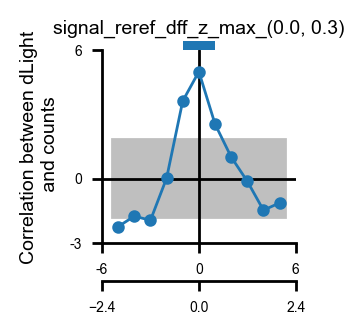

In [23]:
for neural_feature in tqdm(use_features):
    fig, ax = plt.subplots(1, figsize=(1.25, 1.25))
    ax.plot(
        obs_mu.xs(use_beh_feature, level="feature")[neural_feature],
        marker="o",
        ms=3.5,
        color=use_color,
    )
    ax.set_ylabel("Correlation between dLight\n and counts")
    # ax.set_xlabel("n(syllables) from dLight window")
    ax.fill_between(ax.get_xlim(), -cutoff, +cutoff, zorder=-150, facecolor=[0.75] * 3)
    ax.set_ylim(-3, 6)
    ax.set_xlim(-5.5, 5.5)
    ax.axvline(x=0, color=plt.rcParams["axes.edgecolor"], zorder=-100)
    ax.axhline(y=0, color=plt.rcParams["axes.edgecolor"], zorder=-100)
    clean_ticks(ax, "y", precision=0, dtype=int, zero_symmetry=False)
    clean_ticks(ax, "x", precision=0, dtype=int)

    offset = ax.get_ylim()[1] * 0.9
    height = (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.0

    keys = [use_beh_feature]
    key_level = "feature"
    plot_pval(
        pval_df[neural_feature],
        keys,
        key_level,
        ax=ax,
        colors=[use_color],
        offset=1.0,
        height=0.05,
        spacing=1.3,
        min_width=0,
        alpha_threshold=alpha_thresh,
        continuity_threshold=continuity_thresh,
    )

    syllables_to_time = lambda x: x * duration
    time_to_syllables = lambda x: x / duration

    # ax[0].set_xticks([0,25,50])
    secax_x = ax.secondary_xaxis(-0.2, functions=(syllables_to_time, time_to_syllables))
    secax_x.set_ticks([-2.4, 0, 2.4])
    sns.despine()
    ax.set_title(neural_feature, fontsize=7)
    savefig(
        fig,
        os.path.join(figure_cfg["store_dir"], f"endo_usage_stdp_{neural_feature}"),
        bbox_inches="tight",
    )

In [24]:
import json

In [25]:
with open(
    os.path.join(proc_dirs["dlight"], "stats_lagged_usage_shifted_lags.toml"), "w"
) as f:
    plt_json = json.loads(
        pval_df.loc["count", "signal_reref_dff_z_max_(0.0, 0.3)"].to_json()
    )
    plt_json["stat_type"] = "Pearson correlation"
    plt_json["p_type"] = "Comparison to shuffle"
    toml.dump(plt_json, f)